In [35]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [36]:
#check gpu
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [37]:
# load data

train = keras.utils.image_dataset_from_directory(
    "Data/CIFAKE/train",
    labels="inferred",
    label_mode="categorical",
    image_size=(48, 48),
    batch_size=32,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
)

# Create a validation dataset from the training data
val = keras.utils.image_dataset_from_directory(
    "Data/CIFAKE/train",
    labels="inferred",
    label_mode="categorical",
    image_size=(48, 48),
    batch_size=32,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
)

test = keras.utils.image_dataset_from_directory(
    "Data/CIFAKE/test",
    labels="inferred",
    label_mode="categorical",
    image_size=(48, 48),
    batch_size=32,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
)



Found 100000 files belonging to 2 classes.
Using 80000 files for training.
Found 100000 files belonging to 2 classes.
Using 20000 files for validation.
Found 20000 files belonging to 2 classes.
Using 4000 files for validation.


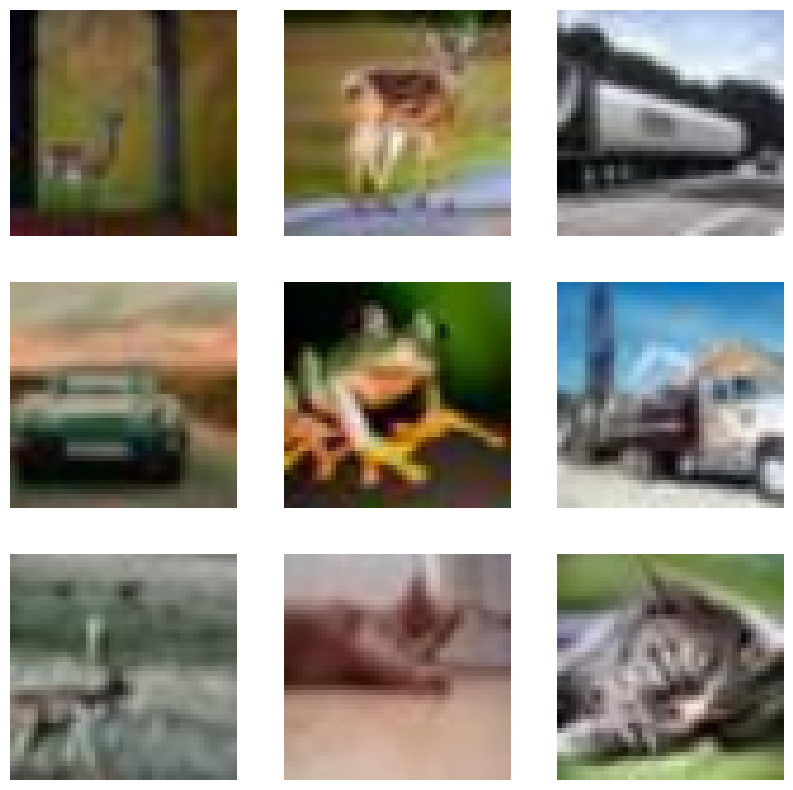

In [72]:
#plot data
images, labels = next(iter(train))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [73]:
print(images[1])

tf.Tensor(
[[[ 19.         23.          0.       ]
  [ 19.5        23.5         0.       ]
  [ 20.         24.          0.       ]
  ...
  [ 31.166685   30.333347    0.       ]
  [ 32.5        29.          0.       ]
  [ 29.         24.          0.       ]]

 [[ 23.         25.          0.       ]
  [ 23.5        25.5         0.       ]
  [ 24.083332   26.          0.       ]
  ...
  [ 34.083344   31.33334     0.       ]
  [ 33.         27.25        0.       ]
  [ 29.         21.5         0.       ]]

 [[ 34.000004   32.500004    4.833336 ]
  [ 34.500004   33.000004    4.916669 ]
  [ 35.194447   33.555557    5.055558 ]
  ...
  [ 42.83334    36.694443    4.500001 ]
  [ 42.16667    32.91667     6.3333364]
  [ 40.83334    29.83334     8.500004 ]]

 ...

 [[115.166626  116.3333    131.16663  ]
  [112.3333    115.91663   129.83328  ]
  [108.833305  115.05553   128.22218  ]
  ...
  [174.30557   158.36111   158.11111  ]
  [175.08334   157.16667   156.33334  ]
  [175.33334   156.33334   155.  

In [39]:
# 0 = fake, 1 = real

In [40]:
# Model

model = keras.Sequential([
    keras.Input(shape=(48, 48, 3)),
    tf.keras.layers.Rescaling(1. / 255),
    layers.Conv2D(512, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])

In [41]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
)

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 48, 48, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 512)       14336     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 512)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 512)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 256)       1179904   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 256)      0         
 2D)                                                    

In [43]:
# SGD optimizer

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val.cache().prefetch(buffer_size=AUTOTUNE)
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [44]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('models/model_{epoch:02d}.h5', save_weights_only=False, save_best_only=False)


In [45]:
"""# Get the class names
class_names = train.class_names

# Initialize a dictionary to store the counts
class_counts = {class_name: 0 for class_name in class_names}

# Loop over the dataset and count the labels
for images, labels in train:
    for label in labels:
        class_name = class_names[np.argmax(label)]
        class_counts[class_name] += 1

# Print the counts
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")"""

'# Get the class names\nclass_names = train.class_names\n\n# Initialize a dictionary to store the counts\nclass_counts = {class_name: 0 for class_name in class_names}\n\n# Loop over the dataset and count the labels\nfor images, labels in train:\n    for label in labels:\n        class_name = class_names[np.argmax(label)]\n        class_counts[class_name] += 1\n\n# Print the counts\nfor class_name, count in class_counts.items():\n    print(f"{class_name}: {count}")'

In [46]:
model.fit(train, epochs=10, validation_data=val, callbacks=[checkpoint,early_stopping])

Epoch 1/10


2024-03-20 23:59:36.539877: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-20 23:59:37.039053: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x39c0bcd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-20 23:59:37.039103: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-03-20 23:59:37.055479: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-20 23:59:37.317386: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2499/2500 [============================>.] - ETA: 0s - loss: 0.4205 - accuracy: 0.8055

2024-03-21 00:00:23.892459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [20000]
	 [[{{node Placeholder/_0}}]]
2024-03-21 00:00:23.892755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [20000]
	 [[{{node Placeholder/_0}}]]


2500/2500 [==============================] - 53s 20ms/step - loss: 0.4205 - accuracy: 0.8055 - val_loss: 0.3095 - val_accuracy: 0.8694
Epoch 2/10
2500/2500 [==============================] - 49s 20ms/step - loss: 0.2859 - accuracy: 0.8810 - val_loss: 0.2961 - val_accuracy: 0.8708
Epoch 3/10
2500/2500 [==============================] - 49s 20ms/step - loss: 0.2416 - accuracy: 0.9023 - val_loss: 0.2218 - val_accuracy: 0.9117
Epoch 4/10
2500/2500 [==============================] - 49s 19ms/step - loss: 0.2175 - accuracy: 0.9120 - val_loss: 0.2069 - val_accuracy: 0.9183
Epoch 5/10
2500/2500 [==============================] - 49s 20ms/step - loss: 0.2001 - accuracy: 0.9206 - val_loss: 0.1953 - val_accuracy: 0.9226
Epoch 6/10
2500/2500 [==============================] - 48s 19ms/step - loss: 0.1863 - accuracy: 0.9264 - val_loss: 0.1856 - val_accuracy: 0.9262
Epoch 7/10
2500/2500 [==============================] - 48s 19ms/step - loss: 0.1724 - accuracy: 0.9319 - val_loss: 0.1722 - val_accura

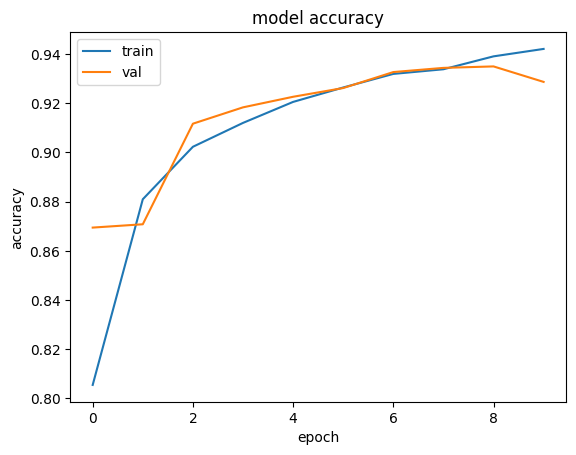

In [47]:
#plot accuracy history
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [48]:
model_from_file = keras.models.load_model('models/model_04.h5')
model_from_file.evaluate(test)

  4/125 [..............................] - ETA: 2s - loss: 0.2627 - accuracy: 0.8828 

2024-03-21 00:07:50.434883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4000]
	 [[{{node Placeholder/_0}}]]
2024-03-21 00:07:50.435177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4000]
	 [[{{node Placeholder/_4}}]]


125/125 [==============================] - 1s 9ms/step - loss: 0.2116 - accuracy: 0.9143


[0.21163608133792877, 0.9142500162124634]

In [135]:
from PIL import Image
def predict_and_return_label(img_path: str, model_from_file) -> tuple:

    from PIL import Image
    img = Image.open(img_path).resize((48, 48))
    img = np.array(img)
    
    prediction = model_from_file.predict(np.expand_dims(img,axis=0))
    
    pri,t(arg)

    # Interpret the prediction
    if prediction[0][0] > prediction[0][1]:
        return 'fake', prediction[0][0]
    else:
        return 'real', prediction[0][1]

In [138]:
predict_and_return_label("Data/kiki/Portrait_Rodeo-3.jpg", model_from_file)

1/1 [==============================] - 0s 17ms/step


('fake', 0.9999969)

In [100]:
np.argmax(model_from_file.predict(np.expand_dims(tf.keras.utils.load_img('Data/kiki/Emma_Paris-08-2.jpg', target_size=(48,48)),
                                                 axis=0)))

1/1 [==============================] - 0s 17ms/step


0

In [104]:
image_tensor = tf.keras.utils.load_img('Data/kiki/Emma_Paris-08-2.jpg', target_size=(48,48), color_mode='rgb')

print(image_tensor)

<PIL.Image.Image image mode=RGB size=48x48 at 0x7FD2809CCCD0>


(48, 48, 3)
